In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
from banksy.main import median_dist_to_nearest_neighbour
from banksy.initialize_banksy import initialize_banksy
from banksy.embed_banksy import generate_banksy_matrix
from banksy.main import concatenate_all
from banksy_utils.umap_pca import pca_umap
from banksy.cluster_methods import run_Leiden_partition
from banksy.plot_banksy import plot_results
import matplotlib.pyplot as plt
import warnings

/autodl-fs/data/viszip/banksy/cluster_methods.py:18: UserWarning: 
No rpy2 installed. BANKSY will run, but mclust will not work.
Note: you can still use the default leiden option for clustering.
Install rpy2 and R in your conda environment if you want to use mclust for clustering.

  warnings.warn(warn_str)


In [2]:
warnings.filterwarnings("ignore")
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

adata = sc.read_h5ad('./visium_hd_adata.h5ad')
adata.var_names_make_unique()
adata.obs['sample'] = 'P1_CRC'

In [3]:

# 质控
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
adata.var['ribo'] = adata.var_names.str.upper().str.startswith(("RPS", "RPL"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['log10GenesPerUMI'] = np.log10(adata.obs['n_genes_by_counts']) / np.log10(adata.obs['total_counts'])

In [4]:
# 细胞过滤
sc.pp.filter_cells(adata, min_counts=20)
sc.pp.filter_cells(adata, max_counts=800)
sc.pp.filter_genes(adata, min_cells=5)
adata = adata[
    (adata.obs['log10GenesPerUMI'] > 0.8) & (adata.obs['log10GenesPerUMI'] < 0.99) & (adata.obs['pct_counts_mt'] < 15)]

In [5]:
# Normalize
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)

In [6]:
# HVG
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat',
    n_top_genes=2000
)
adata.raw = adata  # 保存原始数据
adata = adata[:, adata.var.highly_variable]

In [7]:
if 'array_col' in adata.obs.columns and 'array_row' in adata.obs.columns:
    # 创建 spatial 坐标矩阵
    spatial_coords = np.column_stack([
        adata.obs['array_col'].values,
        adata.obs['array_row'].values
    ])
    adata.obsm['spatial'] = spatial_coords
    print("手动创建 adata.obsm['spatial'] 成功")

手动创建 adata.obsm['spatial'] 成功



Median distance to closest cell = 1.0

---- Ran median_dist_to_nearest_neighbour in 1.16 s ----


Median distance to closest cell = 1.0

---- Ran median_dist_to_nearest_neighbour in 1.14 s ----

---- Ran generate_spatial_distance_graph in 2.33 s ----

---- Ran row_normalize in 0.87 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 8.86 s ----

----- Plotting Edge Histograms for m = 0 -----

Edge weights (distances between cells): median = 2.0, mode = 2.2258449416631976

---- Ran plot_edge_histogram in 0.13 s ----


Edge weights (weights between cells): median = 0.05578200987743516, mode = 0.027551009657983048

---- Ran plot_edge_histogram in 0.13 s ----

---- Ran generate_spatial_distance_graph in 3.46 s ----

---- Ran theta_from_spatial_graph in 2.40 s ----

---- Ran row_normalize in 0.87 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 12.78 s ----

----- Plotting Edge Histograms for m = 1 -----

Edge weights (distances between cells): median = 2.23606797749979, mode = 

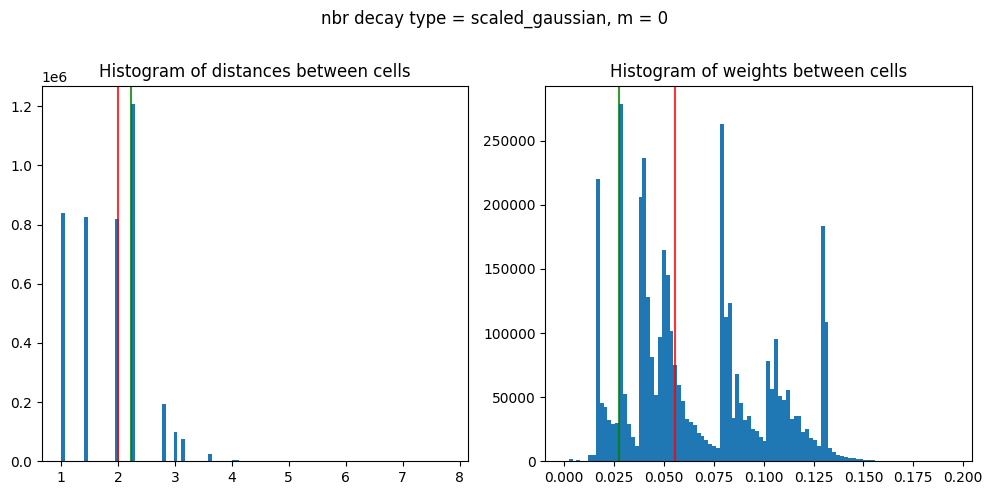

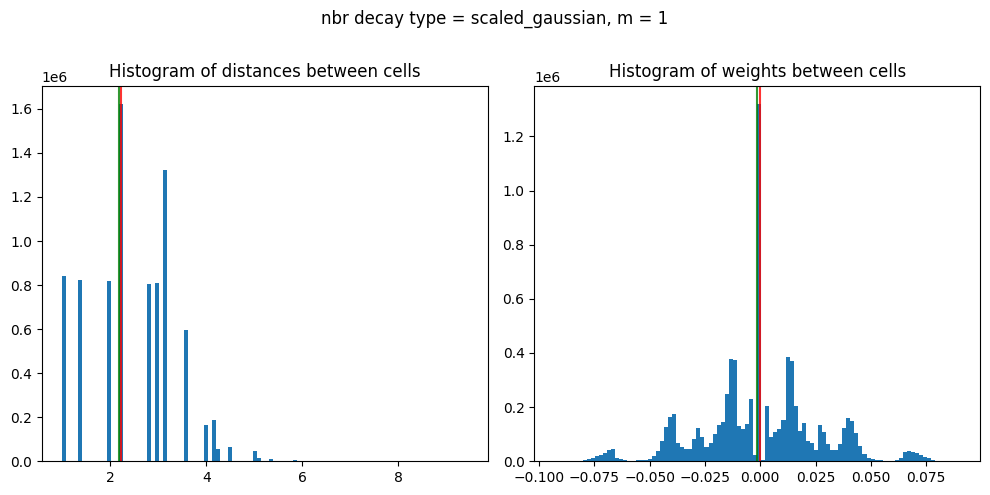

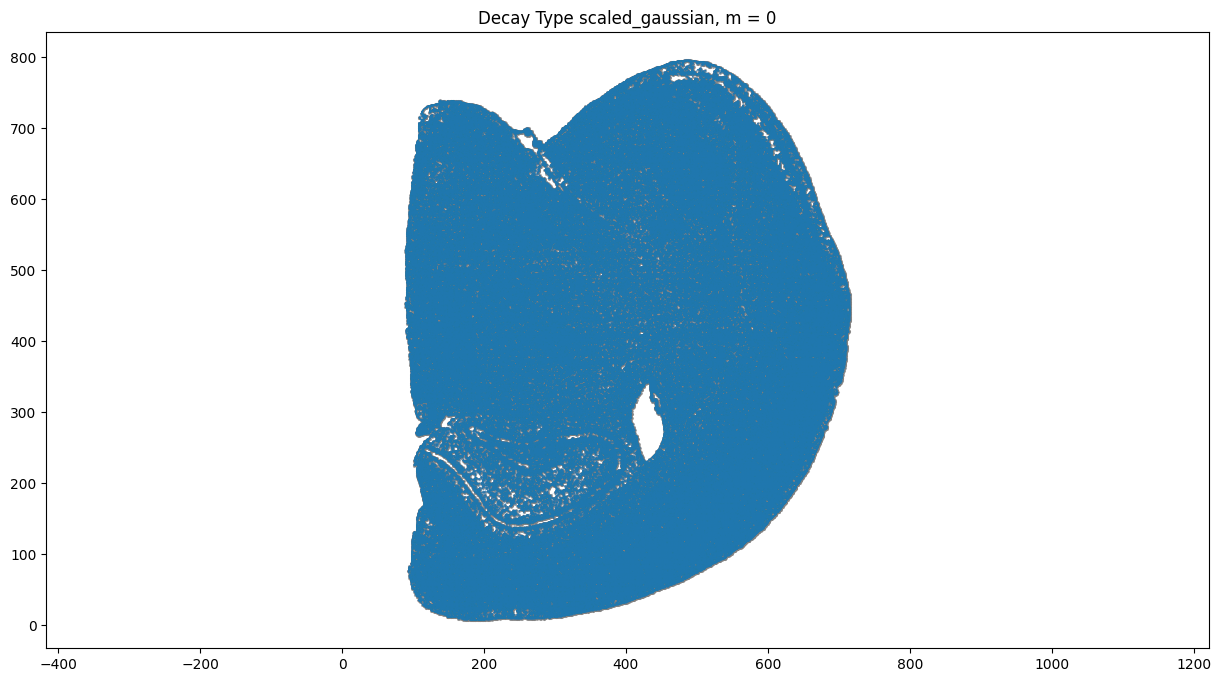

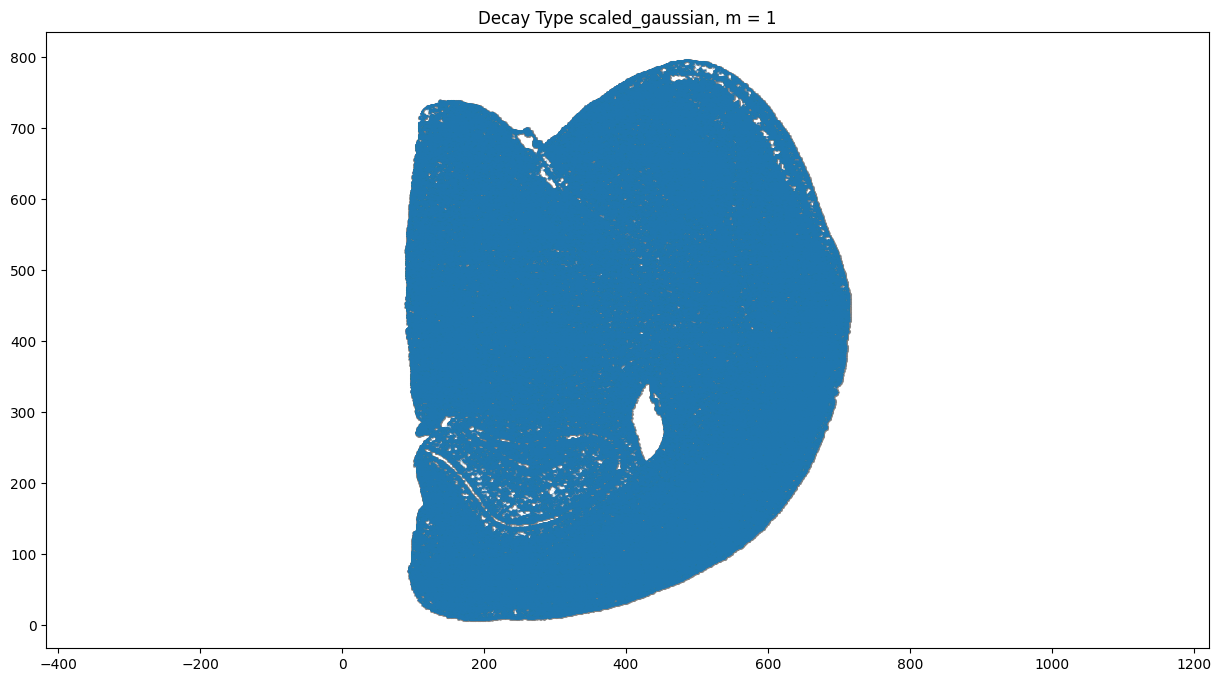

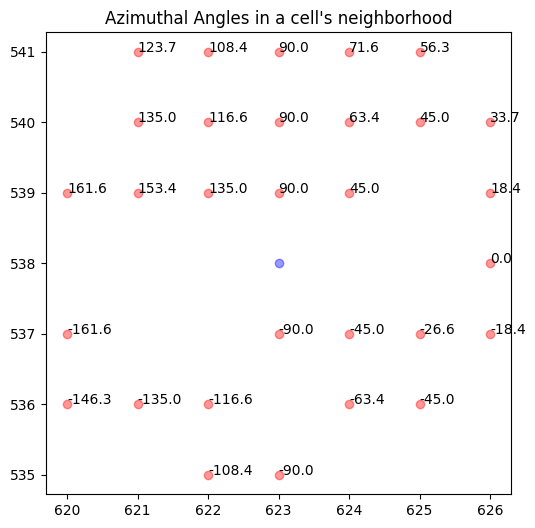

In [8]:
## 构建空间最近邻图
# Find median distance to closest neighbours
nbrs = median_dist_to_nearest_neighbour(adata, key="spatial")

## 生成距离空间权重(Generate spatial weights from distance)
k_geom = 15  # number of spatial neighbours
max_m = 1  # use both mean and AFT
nbr_weight_decay = "scaled_gaussian"  # can also choose "reciprocal", "uniform" or "ranked"
coord_keys = ('array_col', 'array_row', 'spatial')
banksy_dict = initialize_banksy(
    adata,
    coord_keys,
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=True,  # Visualize the edge histogram to show the histogram of distances between cells and the weights
    plt_nbr_weights=True,  # Visualize weights by plotting the connections.
    plt_agf_angles=False,  # Visualize weights with Azimuthal angles
    plt_theta=True,
    # Visualize angles around random cell. Plot points around a random index cell, annotated with angles from the index cell.
)

In [9]:
# 生成BANKSY矩阵
# BANKSY几个主要超参数
resolutions = [0.5]  # clustering resolution for UMAP
pca_dims = [20]  # Dimensionality in which PCA reduces to
lambda_list = [0.2]  # list of lambda parameters
banksy_dict, banksy_matrix = generate_banksy_matrix(
    adata,
    banksy_dict,
    lambda_list,
    max_m
)

Runtime Jun-13-2025-17-30

2000 genes to be analysed:
Gene List:
Index(['St18', 'Sgk3', 'Tcf24', 'Prex2', 'Crisp4', 'Defb41', 'Mcm3', 'Paqr8',
       'Gsta3', 'Khdc1a',
       ...
       'Car5b', 'Cltrn', 'Piga', 'Gpm6b', 'Tceanc', 'Tlr8', 'Tlr7', 'Uba1y',
       'mt-Nd3', 'mt-Nd6'],
      dtype='object', length=2000)

Check if X contains only finite (non-NAN) values
Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <273368x273368 sparse matrix of type '<class 'numpy.float64'>'
	with 4100520 stored elements in Compressed Sparse Row format>, 1: <273368x273368 sparse matrix of type '<class 'numpy.complex128'>'
	with 8201040 stored elements in Compressed Sparse Row format>}}

Nbr matrix | Mean: 0.0 | Std: 0.03
Size of Nbr | Shape: (273368, 2000)
Top 3 entries of Nbr Mat:

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

AGF matrix | Mean: 0.0 | Std: 0.01
Size of AGF mat (m = 1) | Shape: (273368, 2000)
Top entries of AGF:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Ran 'Create BANKSY Matrix' in 1.

In [10]:
## 将非空间结果附加到banksy_dict以进行比较（不必要）
banksy_dict["nonspatial"] = {
    # Here we simply append the nonspatial matrix (adata.X) to obtain the nonspatial clustering results
    0.0: {"adata": concatenate_all([adata.X], 0, adata=adata), }
}

Scale factors squared: [1.]
Scale factors: [1.]


In [11]:
## PCA降维, UMAP可视化
pca_umap(
    banksy_dict,
    pca_dims=pca_dims,  # 这里PCA降到20个维度
    add_umap=True,
    plt_remaining_var=False,
)

## 细胞聚类--默认情况下，建议使用基于分辨率的聚类（即leiden 或 louvain）
results_df, max_num_labels = run_Leiden_partition(
    banksy_dict,
    resolutions,
    num_nn=50,  # k_expr: number of neighbours in expression (BANKSY embedding or non-spatial) space
    num_iterations=-1,  # run to convergenece
    partition_seed=12345,
    match_labels=True,
)

Current decay types: ['scaled_gaussian', 'nonspatial']

Reducing dims of dataset in (Index = scaled_gaussian, lambda = 0.2)

Setting the total number of PC = 20
Original shape of matrix: (273368, 6000)
Reduced shape of matrix: (273368, 20)
------------------------------------------------------------
min_value = -208.3294230987194, mean = -1.9573793030097884e-16, max = 662.220113694496

Conducting UMAP and adding embeddings to adata.obsm["reduced_pc_20_umap"]
UMAP embedding
------------------------------------------------------------
shape: (273368, 2)


AxisArrays with keys: reduced_pc_20, reduced_pc_20_umap

Reducing dims of dataset in (Index = nonspatial, lambda = 0.0)

Setting the total number of PC = 20
Original shape of matrix: (273368, 2000)
Reduced shape of matrix: (273368, 20)
------------------------------------------------------------
min_value = -230.77035522460938, mean = 4.446484638265247e-07, max = 639.4998168945312

Conducting UMAP and adding embeddings to adata.obsm["re

decay  lambda_param  num_pcs  \
nonspatial_pc20_nc0.00_r0.50            nonspatial           0.0       20   
scaled_gaussian_pc20_nc0.20_r0.50  scaled_gaussian           0.2       20   

                                   resolution  num_labels  \
nonspatial_pc20_nc0.00_r0.50              0.5          17   
scaled_gaussian_pc20_nc0.20_r0.50         0.5          16   

                                                                              labels  \
nonspatial_pc20_nc0.00_r0.50       Label object:\nNumber of labels: 17, number of...   
scaled_gaussian_pc20_nc0.20_r0.50  Label object:\nNumber of labels: 16, number of...   

                                                                               adata  \
nonspatial_pc20_nc0.00_r0.50       [[[View of AnnData object with n_obs × n_vars ...   
scaled_gaussian_pc20_nc0.20_r0.50  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
nonspatial_pc20_nc0.00_r0.50       Label object:\nNumber of labels: 17, number of...  
scaled_gaussian_pc20_nc0.20_r0.50  Label object:\nNumber of labels: 16, number of...

Saving figure at tmp_png/slideseq_mousecerebellum_nonspatial_pc20_nc0.00_r0.50_spatialmap.png
number of labels: 17
---- Ran plot_2d_embeddings in 0.03 s ----

number of labels: 17
---- Ran plot_2d_embeddings in 0.04 s ----

number of labels: 17
---- Ran plot_2d_embeddings in 0.03 s ----

---- Ran row_normalize in 0.00 s ----


matrix multiplying labels x weights x labels-transpose ((17, 273368) x (273368, 273368) x (273368, 17))

Saving figure at tmp_png/slideseq_mousecerebellum_scaled_gaussian_pc20_nc0.20_r0.50_spatialmap.png
number of labels: 16
---- Ran plot_2d_embeddings in 0.03 s ----

number of labels: 16
---- Ran plot_2d_embeddings in 0.06 s ----

number of labels: 16
---- Ran plot_2d_embeddings in 0.04 s ----

---- Ran row_normalize in 0.00 s ----


matrix multiplying labels x weights x labels-transpose ((16, 273368) x (273368, 273368) x (273368, 16))



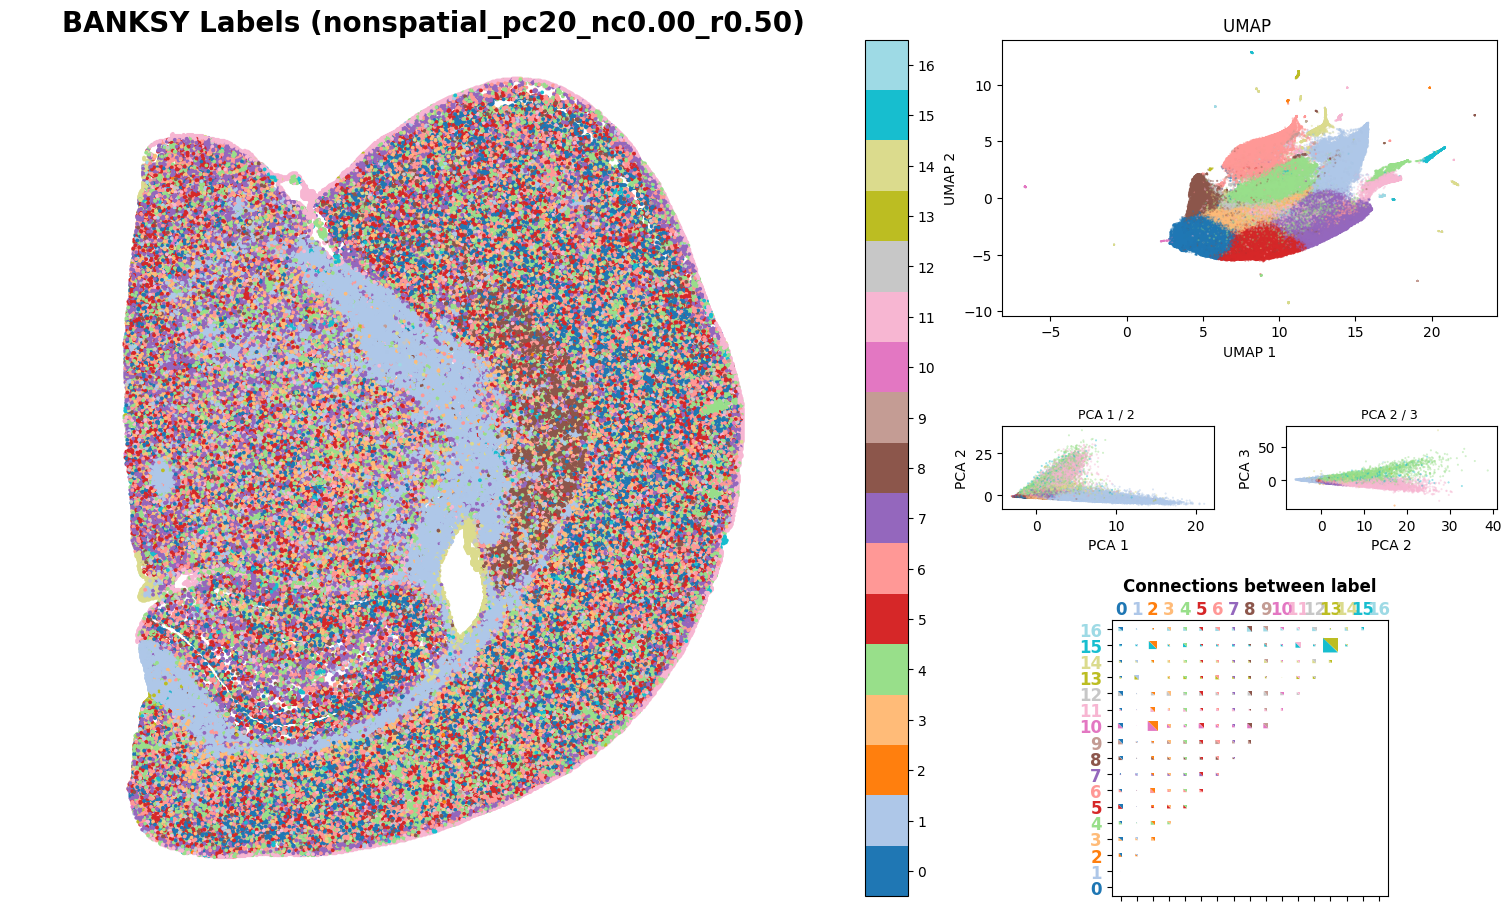

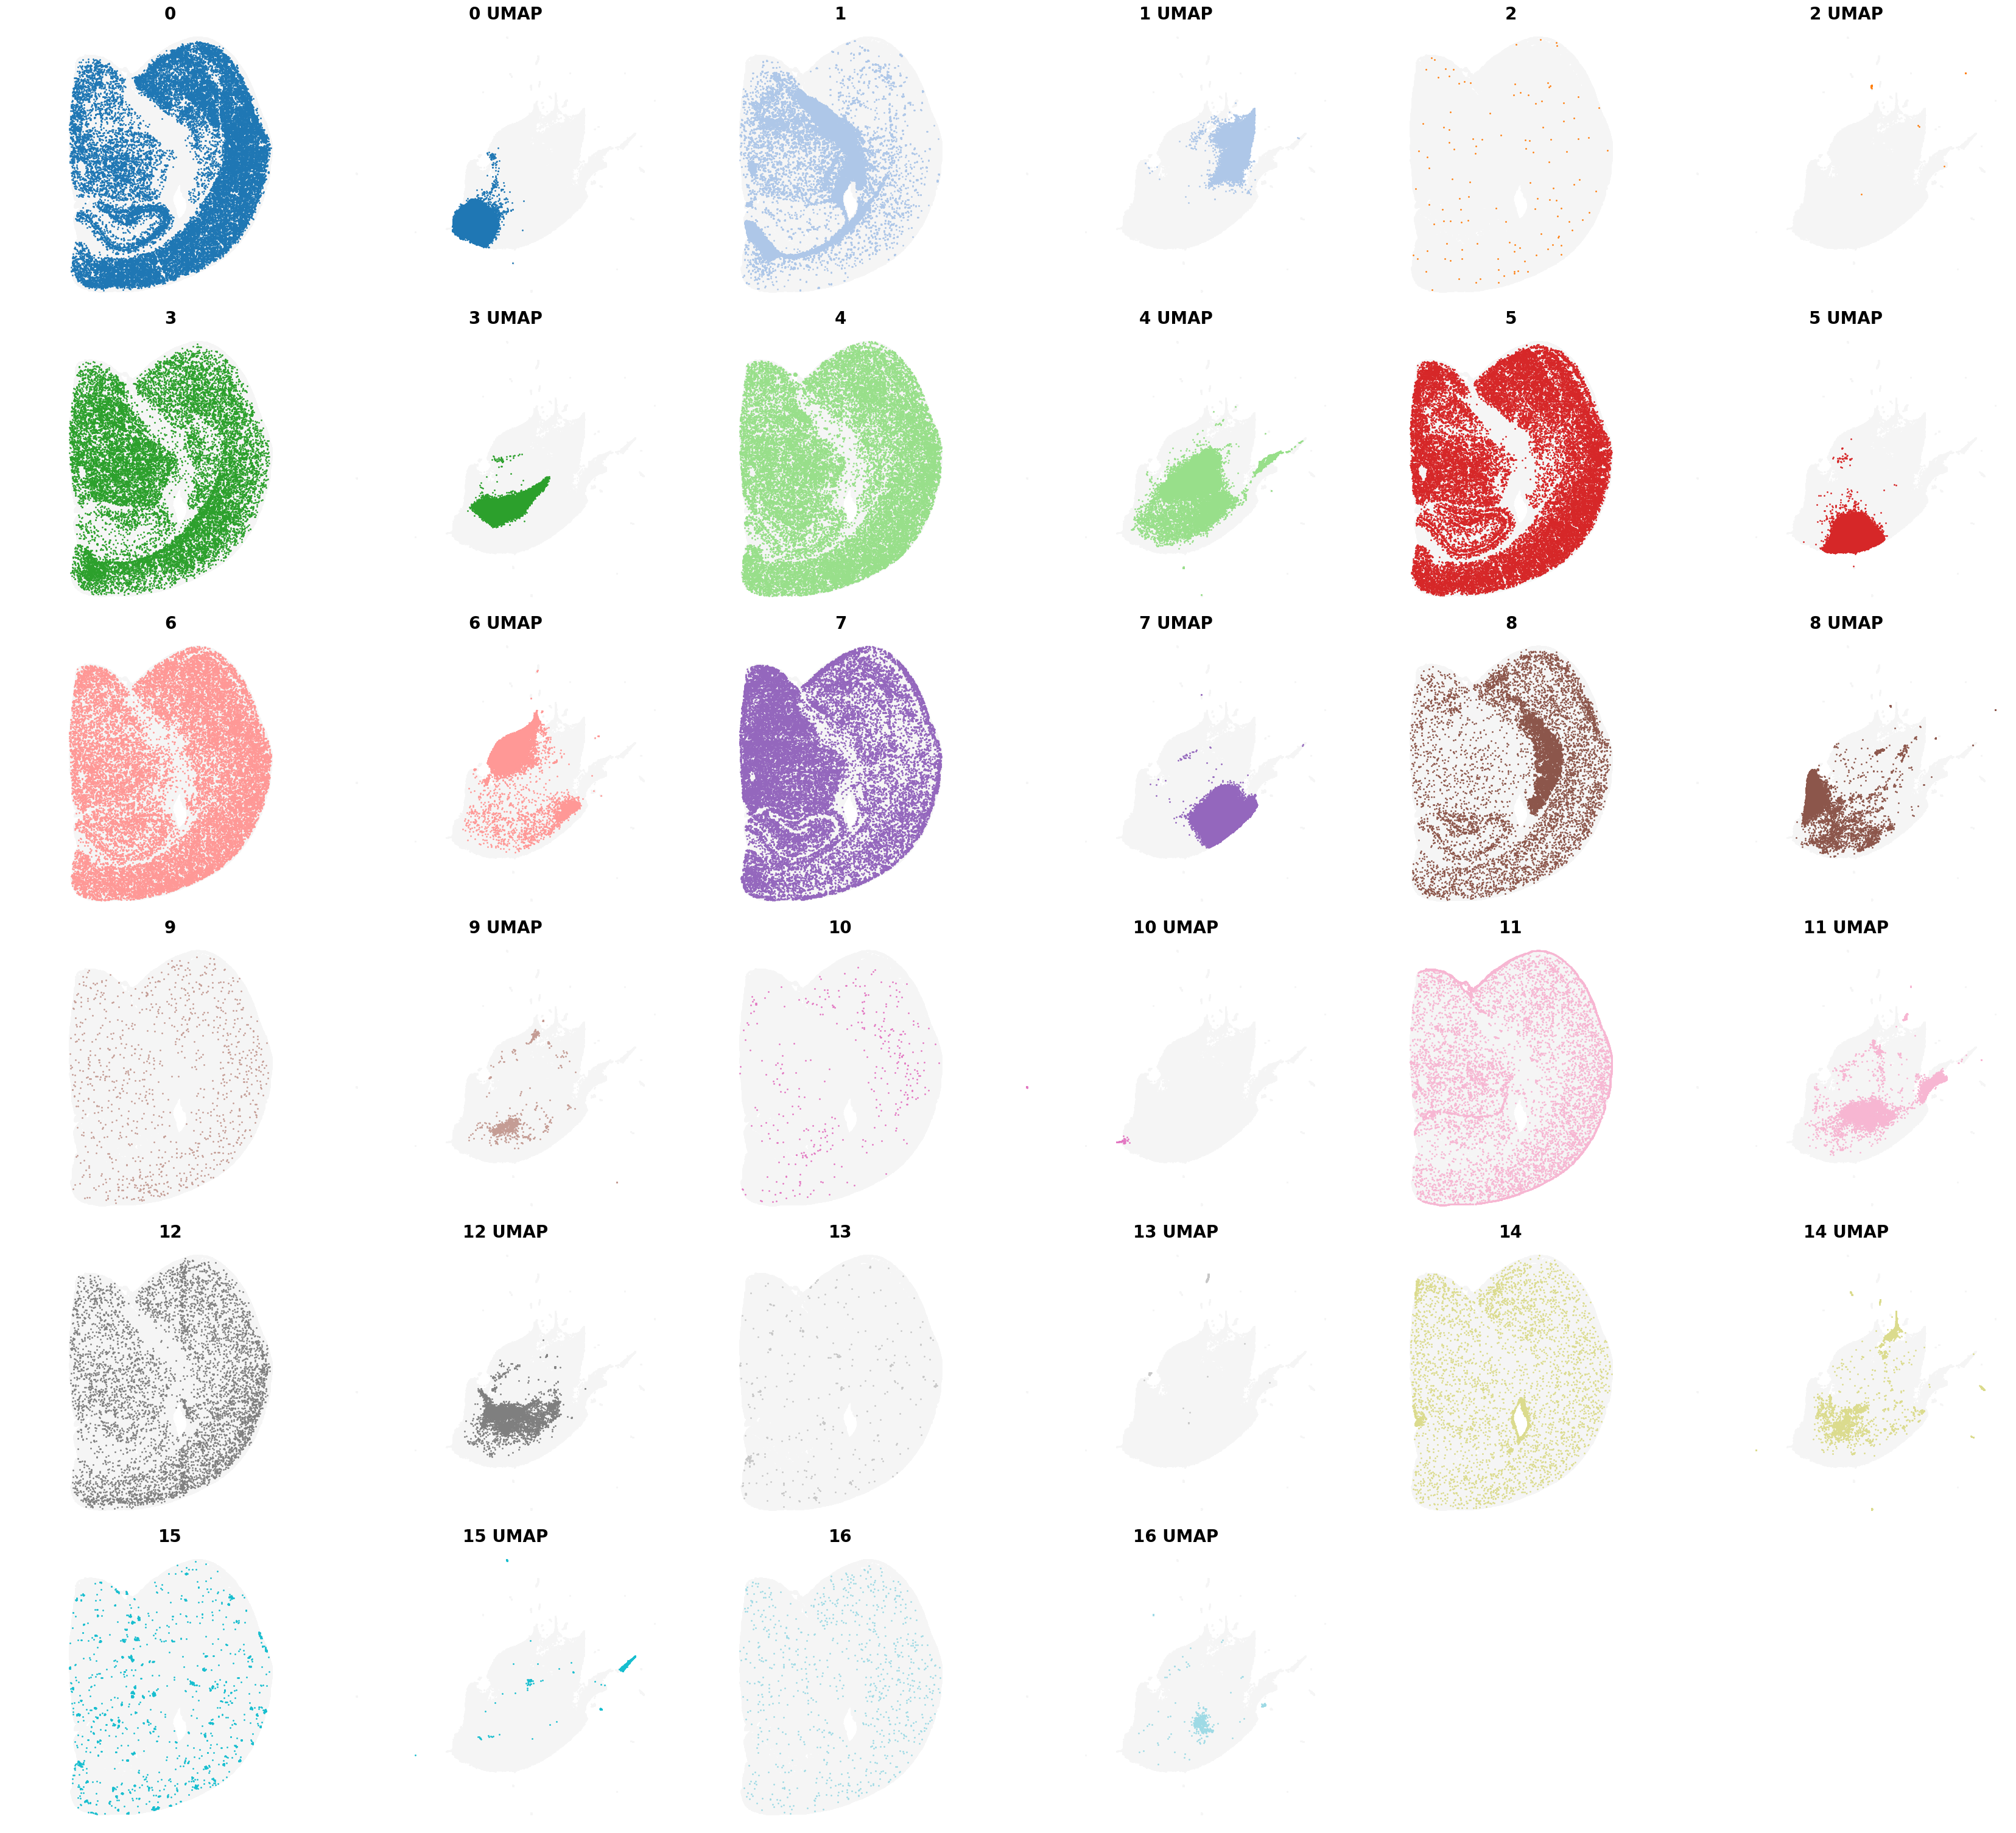

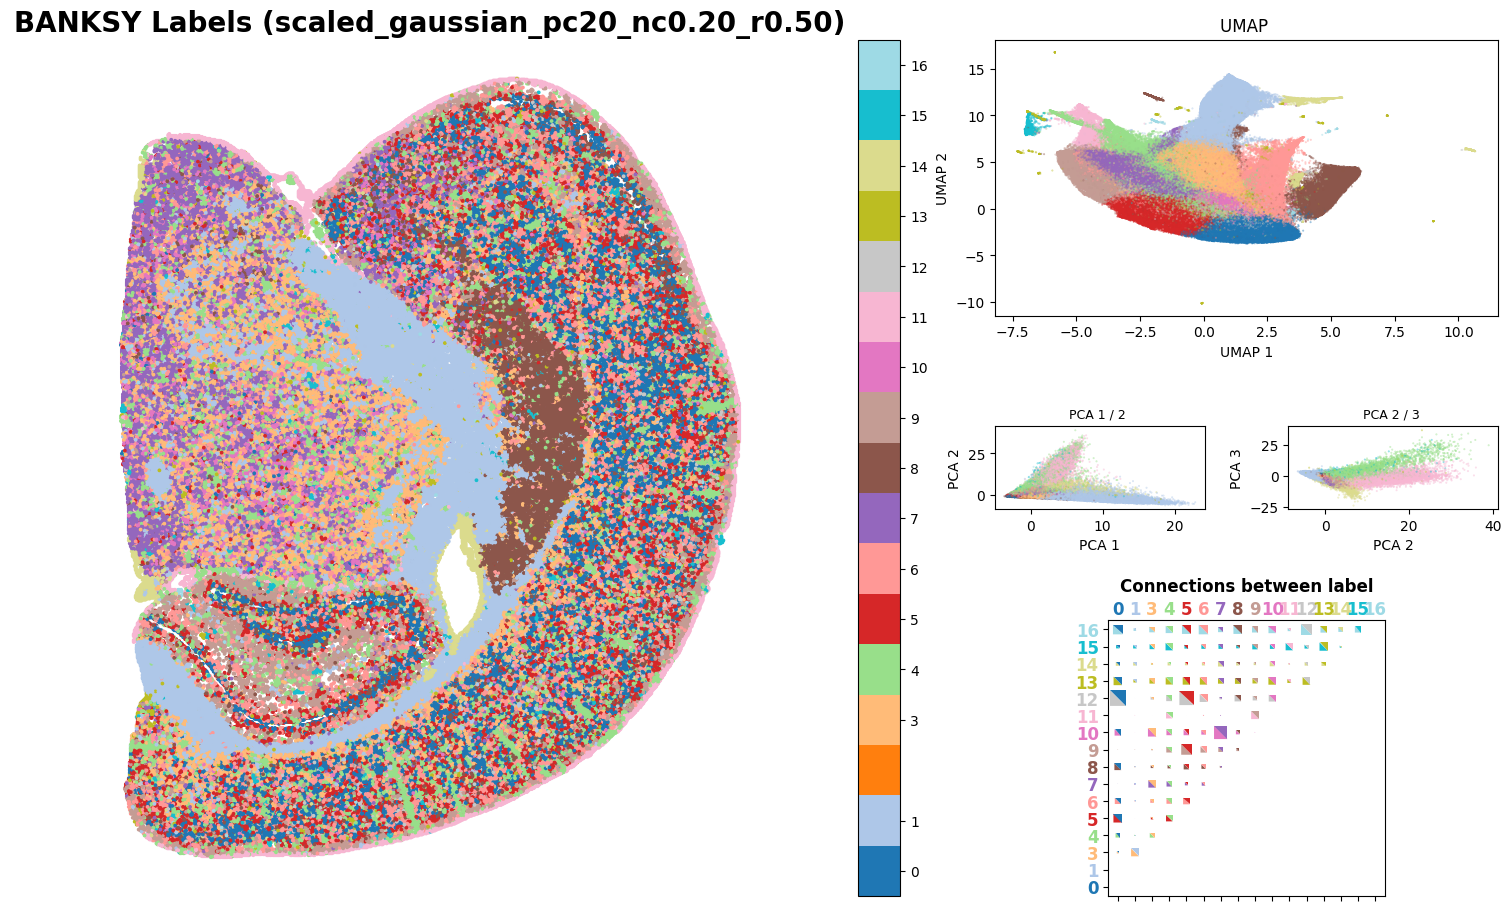

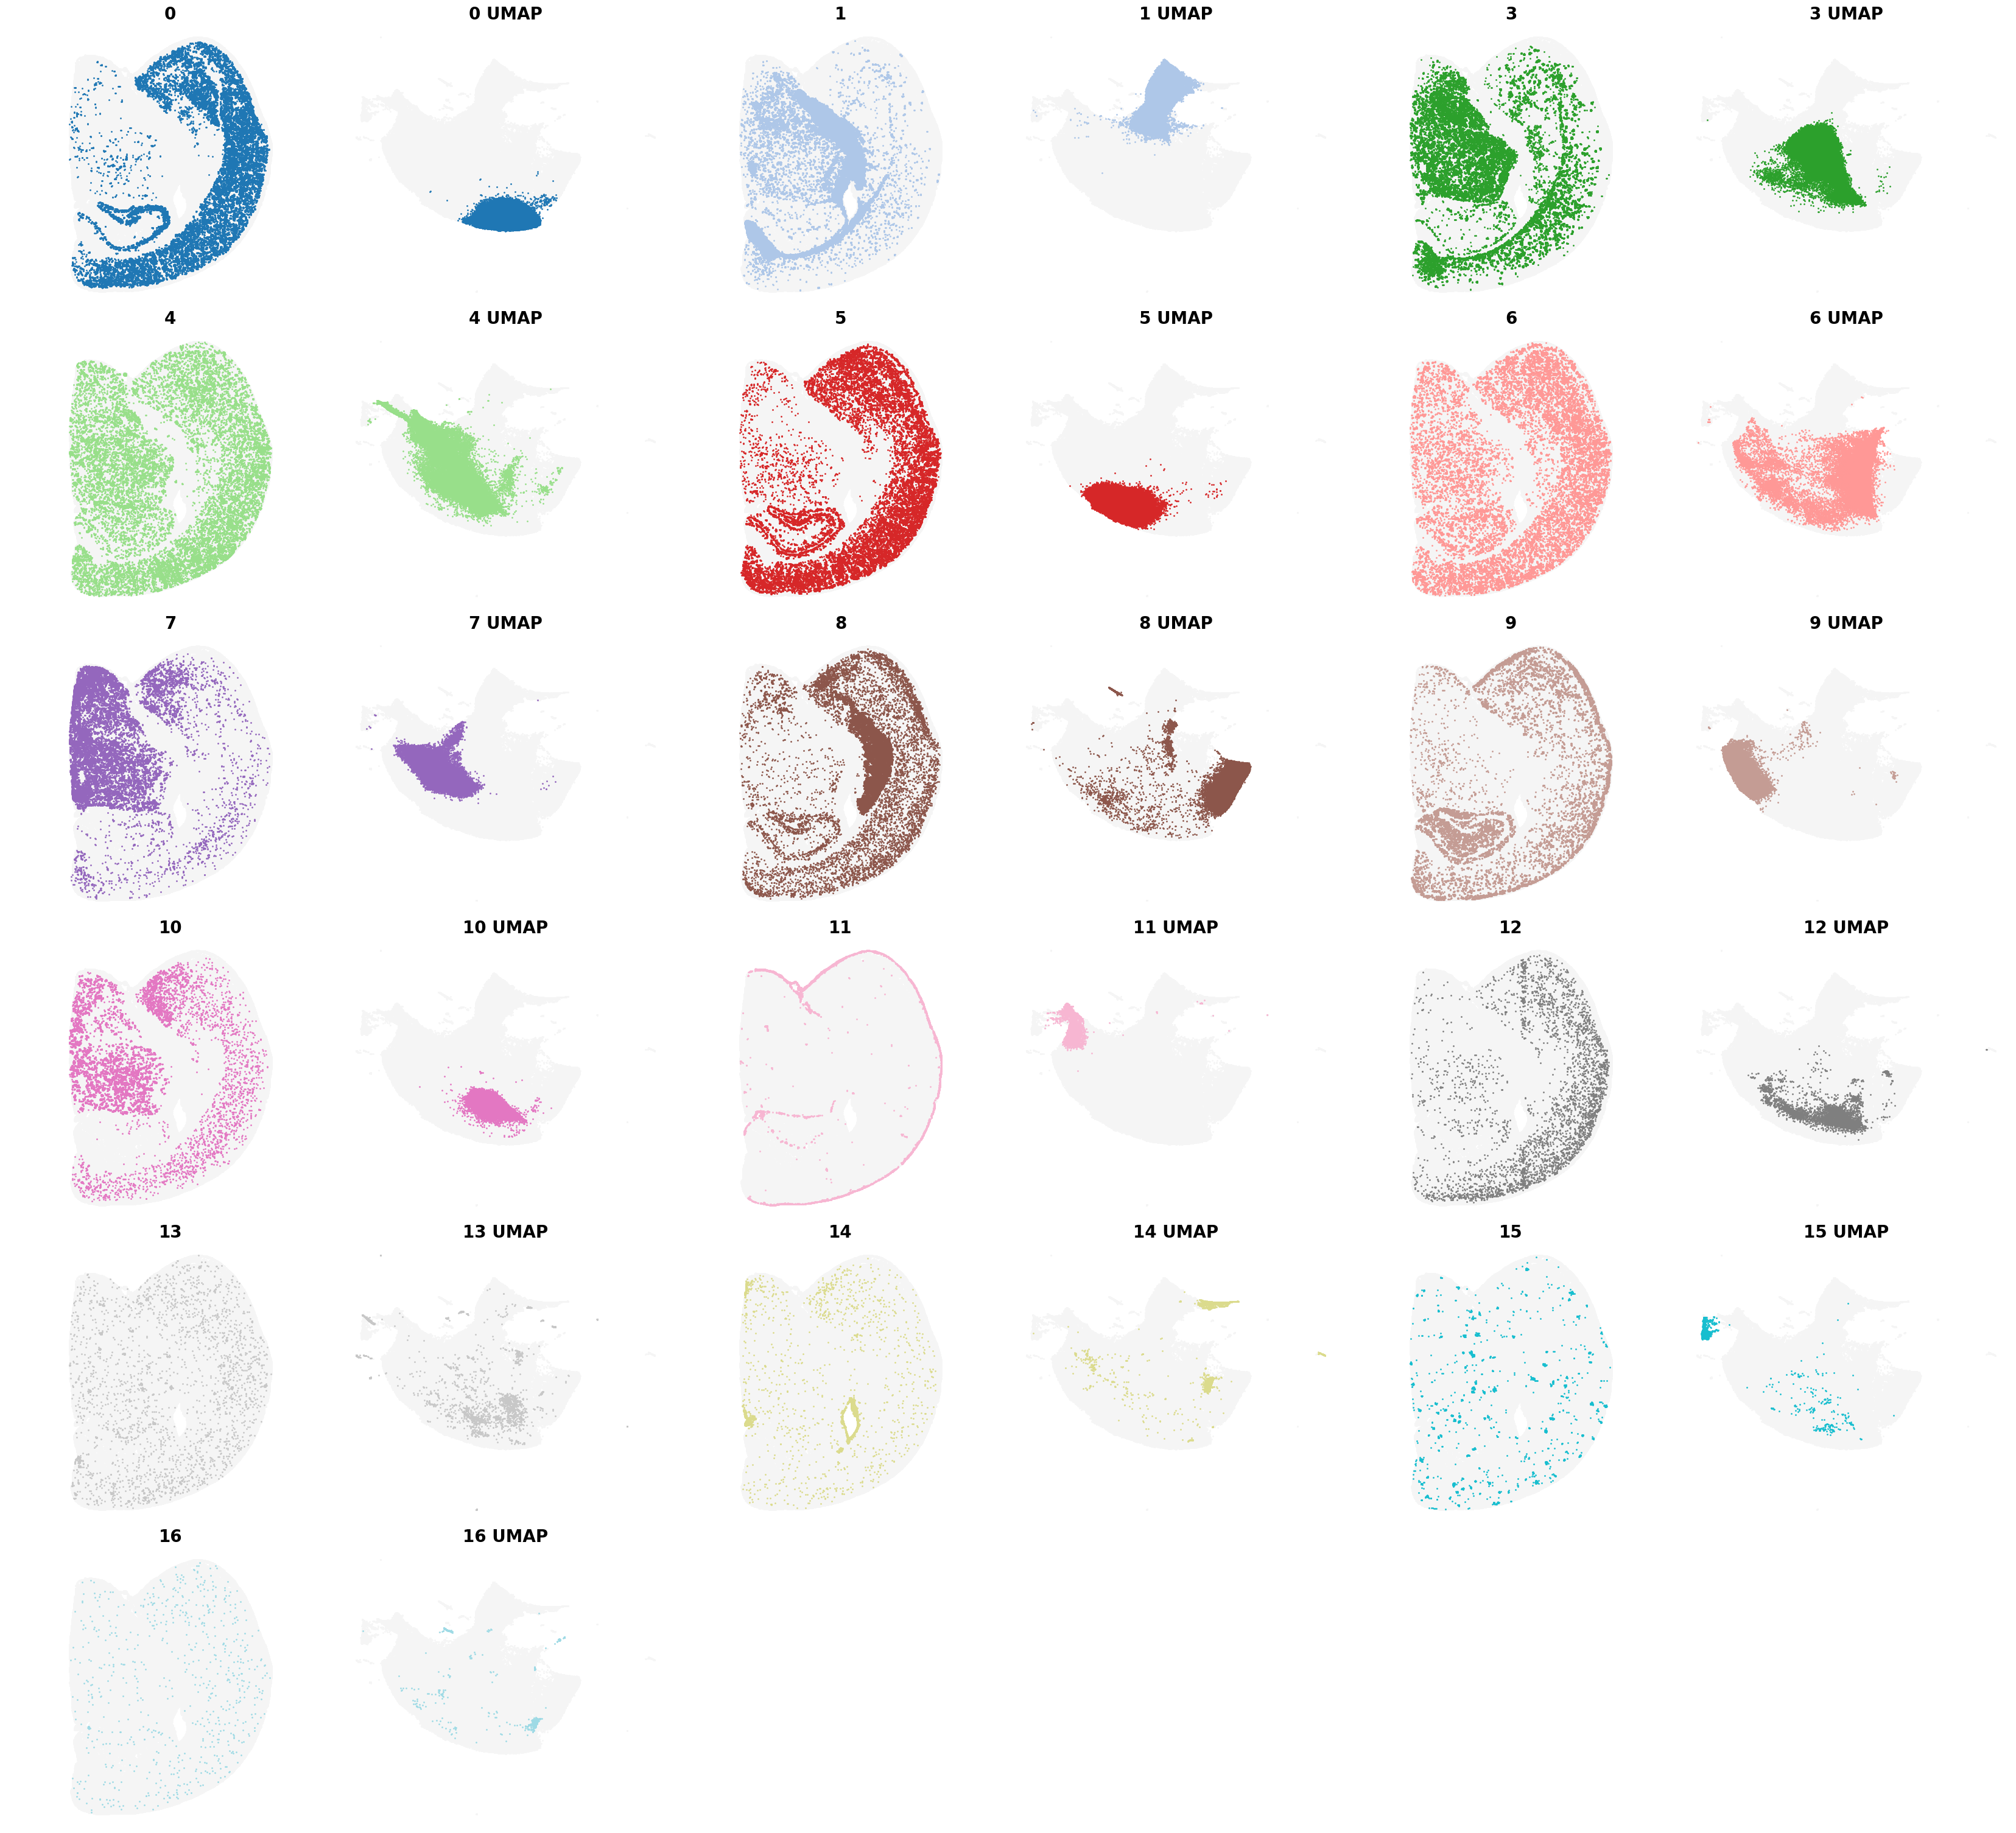

In [12]:
from banksy.plot_banksy import plot_results
c_map =  'tab20' # specify color map
weights_graph =  banksy_dict['scaled_gaussian']['weights'][0]
plot_results(
    results_df,
    weights_graph,
    c_map,
    match_labels = True,
    coord_keys = coord_keys,
    max_num_labels  =  max_num_labels,
    save_path = 'tmp_png',
    save_fig = True
)

In [13]:
from banksy_utils.cluster_utils import pad_clusters, create_spatial_nonspatial_adata,  refine_cell_types
# 手动为选定的聚类分配生物学身份标注
cluster2annotation_spatial = {
    "0": "Outer_Cortical_Layer",        # 外层皮质层 - 浅蓝色，边缘连续分布
    "1": "Inner_Cortical_Layer",        # 内层皮质层 - 深蓝色，内侧主要区域  
    "7": "Intermediate_Zone",           # 中间过渡区 - 紫色，连接不同区域
    "8": "Specialized_Niche",           # 特化生态位 - 棕色，特定功能区域
    "11": "Boundary_Interface"          # 边界界面 - 暗红色，组织边界区域
}
pad_clusters(cluster2annotation_spatial, list(range(max_num_labels)))

In [14]:
cluster2annotation_nonspatial = {
    "0": "Outer_Cortical_Layer",        # 外层皮质层 - 浅蓝色，边缘连续分布
    "1": "Inner_Cortical_Layer",        # 内层皮质层 - 深蓝色，内侧主要区域  
    "7": "Intermediate_Zone",           # 中间过渡区 - 紫色，连接不同区域
    "8": "Specialized_Niche",           # 特化生态位 - 棕色，特定功能区域
    "11": "Boundary_Interface"          # 边界界面 - 暗红色，组织边界区域
}

print(cluster2annotation_spatial,"\n", cluster2annotation_nonspatial)

# save annotations in two different anndata objects (adata_spatial and adata_nonspatial)

adata_spatial, adata_nonspatial = create_spatial_nonspatial_adata(results_df,
                                    pca_dims,
                                    lambda_list, 
                                    resolutions,
                                    cluster2annotation_spatial,
                                    cluster2annotation_nonspatial)

{'0': 'Outer_Cortical_Layer', '1': 'Inner_Cortical_Layer', '7': 'Intermediate_Zone', '8': 'Specialized_Niche', '11': 'Boundary_Interface', '2': 'other', '3': 'other', '4': 'other', '5': 'other', '6': 'other', '9': 'other', '10': 'other', '12': 'other', '13': 'other', '14': 'other', '15': 'other', '16': 'other'} 
 {'0': 'Outer_Cortical_Layer', '1': 'Inner_Cortical_Layer', '7': 'Intermediate_Zone', '8': 'Specialized_Niche', '11': 'Boundary_Interface'}
scaled_gaussian_pc20_nc0.20_r0.50
nonspatial_pc20_nc0.00_r0.50


In [25]:
from banksy_utils.plot_utils import plot_DE_genes, plot_DE_genes_refined, plot_connection_grid, plot_clusters

cluster2annotation_refine = {
    "Intermediate_Zone" : "other",
}

adata_spatial_filtered, adata_nonspatial_filtered = refine_cell_types(adata_spatial, 
                                                                      adata_nonspatial,
                                                                      cluster2annotation_refine
                                                                      )

In [26]:
adata_self = plot_DE_genes_refined(adata_spatial_filtered, plot_heatmap = False, save_fig = False)

         Falling back to preprocessing with `sc.pp.pca` and default params.


All refined cell types: Index(['Boundary_Interface', 'Inner_Cortical_Layer', 'Outer_Cortical_Layer',
       'Specialized_Niche', 'other'],
      dtype='object')
[1. 1. 1. ... 1. 1. 1.] (273368, 273368)
[1. 1. 1. ... 1. 1. 1.] (273368, 273368)


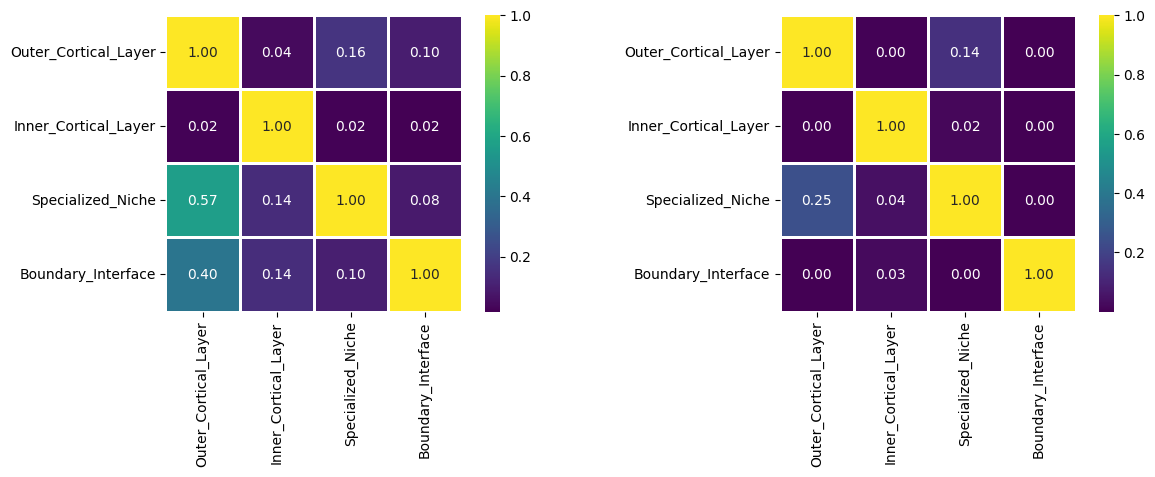

In [27]:
cell_types = ["Outer_Cortical_Layer", 
              "Inner_Cortical_Layer", 
              "Specialized_Niche",
              "Boundary_Interface",]

plot_connection_grid(
    banksy_dict["scaled_gaussian"]["weights"][0].copy(),
    adata_nonspatial,
    adata_spatial,
    cell_types= cell_types,
    save_fig=False
)

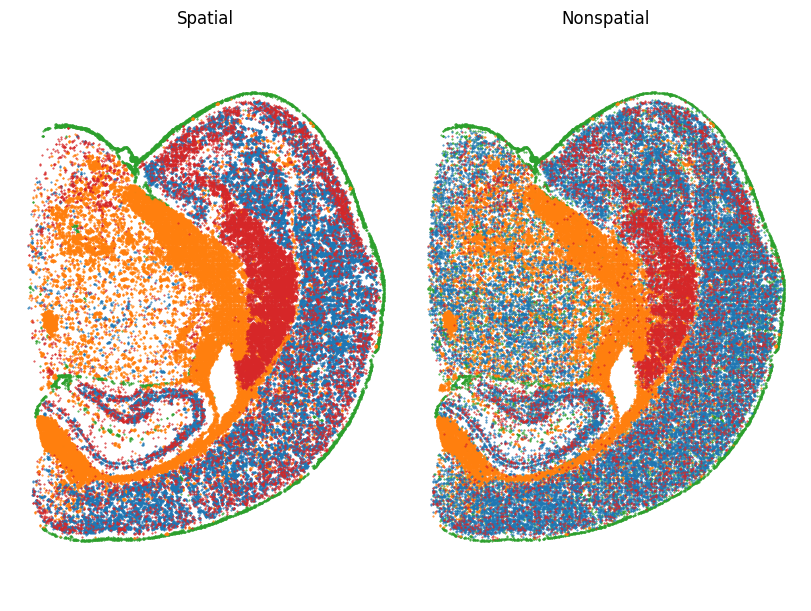

In [29]:
adata_spatial.obsm['coord_xy'] = adata_spatial.obsm['spatial']
adata_nonspatial.obsm['coord_xy'] = adata_nonspatial.obsm['spatial']
# choose colours for each cluster
colors_dict = {
    "Outer_Cortical_Layer":"tab:blue",
    "Inner_Cortical_Layer":"tab:orange",
    "Specialized_Niche":"tab:red",
    "Boundary_Interface":"tab:green",
}

plot_clusters(
    adata_spatial,
    adata_nonspatial,
    colors_dict,
)